<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/DataMinining%20the%20Water%20Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 62 kB 732 kB/s 
     |████████████████████████████████| 1.3 MB 56.1 MB/s 
     |████████████████████████████████| 365 kB 63.2 MB/s 
     |████████████████████████████████| 4.7 MB 56.6 MB/s 
     |████████████████████████████████| 115 kB 56.9 MB/s 
     |████████████████████████████████| 101 kB 10.2 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 141 kB 64.5 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 127 kB 51.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

#Pump it Up: Data Mining the Water Table
HOSTED BY DRIVENDATA

## The Dataset

In [3]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/Water')

In [4]:

Path.BASE_PATH = path

### Look at the Data

In any sort of data science work, it's important to *look at your data directly* to make sure you understand the format, how it's stored, what types of values it holds, etc. Even if you've read a description of the data, the actual data may not be what you expect. We'll start by reading the training set into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

In [5]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [6]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [7]:
dep_var = 'status_group'

In [8]:
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [9]:
combined = pd.concat([df, df_test]) # test will have nans at target, but we don't care
cont_cols, cat_cols = cont_cat_split(combined, max_card=50)
combined = combined[cat_cols]

In [10]:
train = df
test = df_test
train[cont_cols] = train[cont_cols].astype('float') # if target is not float, there will be an error later
test[cont_cols[:-1]] = test[cont_cols[:-1]].astype('float'); # slice target off (I had mine at the end of cont_cols)

In [11]:
procs = [Categorify, FillMissing]

to = TabularPandas(combined,
                   procs = procs,
                   cat_names = cat_cols)

train_to_cat = to.items.iloc[:train.shape[0], :] # transformed cat for train
test_to_cat = to.items.iloc[train.shape[0]:, :] # transformed cat for test. Need to separate them

In [12]:
train_imp = pd.concat([train_to_cat, train[cont_cols]], 1) # assemble new cat and old cont together
test_imp = pd.concat([test_to_cat, test[cont_cols[:-1]]], 1) # exclude target


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

## Decision Trees

A piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [14]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that.

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [15]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [16]:
cont

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [17]:
del cont[0]

In [18]:
cat

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [19]:
splits = RandomSplitter(valid_pct=0.1)(range_of(df))

In [20]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var,splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [21]:
len(to.train),len(to.valid)

(53460, 5940)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [22]:
#hide_output
to.show(3)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
44846,2/16/2013,Government Of Tanzania,District council,Kwa Rogati Tairo,Pangani,Momwe,Kilimanjaro,Rombo,Kirwa Keni,True,GeoData Consultants Ltd,Company,Mrao water supply,True,gravity,gravity,gravity,company,commercial,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0.0,1168.0,37.647003,-3.167315,0.0,3,1,1.0,1974.0,non functional
44810,3/20/2013,Danida,DANIDA,Kwa Mzee Kapinga,Lake Nyasa,Manzeye,Ruvuma,Mbinga,Litembo,#na#,GeoData Consultants Ltd,VWC,DANIDA,True,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,0.0,1759.0,34.851070,-10.966649,0.0,10,3,30.0,1991.0,non functional
2711,2/9/2013,Unicef,UNICEF,Zahanati,Ruvuma / Southern Coast,Minazini,Ruvuma,Tunduru,Namwinyu,False,GeoData Consultants Ltd,VWC,#na#,False,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,0.0,769.0,36.962593,-10.795687,0.0,10,1,1.0,1992.0,non functional


However, the underlying items are all numeric:

In [23]:
#hide_output
to.items.head(3)

,id,amount_tsh,date_recorded,funder,...,source_class,waterpoint_type,waterpoint_type_group,status_group
44846,43130.0,0.0,125,457,...,1,2,2,2
44810,36634.0,0.0,187,262,...,1,2,2,2
2711,69262.0,0.0,160,1742,...,1,5,4,2


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category, in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

In [24]:
save_pickle(path/'to.pkl',to)

To read this back later, you would type:

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

### Creating the Decision Tree

To begin, we define our independent and dependent variables:

In [25]:
#hide
to = load_pickle(path/'to.pkl')

In [26]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Random Forests

### Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
def rf(xs, y, n_estimators=100, max_samples=20000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [29]:
m = rf(xs, y);

In [30]:
yt_pre = m.predict(xs)
yv_pre = m.predict(valid_xs)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yt_pre)


0.8532921810699589

In [32]:
accuracy_score(valid_y, yv_pre)

0.8043771043771044

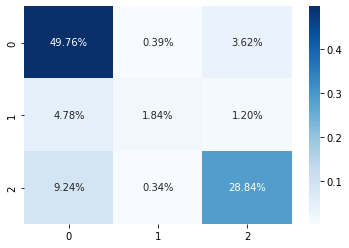

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, yv_pre)
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

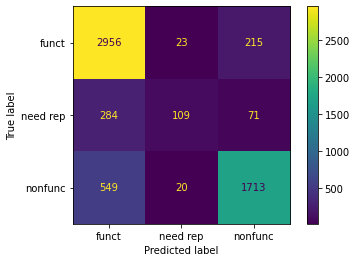

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['funct','need rep','nonfunc'])
disp.plot()
plt.show()

In [35]:
del df_test['id']
to_tst = to.new(df_test)
to_tst.process()
to_tst.items.head()

,amount_tsh,date_recorded,funder,gps_height,...,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,0,308,1996.0,...,4,2,7,6
1,0.0,0,457,1569.0,...,7,1,2,2
2,0.0,0,0,1567.0,...,4,2,7,6
3,0.0,0,396,267.0,...,6,1,7,6
4,500.0,0,135,1260.0,...,7,1,2,2


We are clearly not spoting the need for repairs and 40% of the non functional

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

In [37]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
24,quantity_group,0.102865
23,quantity,0.098592
32,longitude,0.069818
33,latitude,0.062080
29,waterpoint_type_group,0.053528
28,waterpoint_type,0.050562
5,subvillage,0.038127
0,date_recorded,0.037994
38,construction_year,0.037937
3,wpt_name,0.036980


A plot of the feature importances shows the relative importances more clearly:

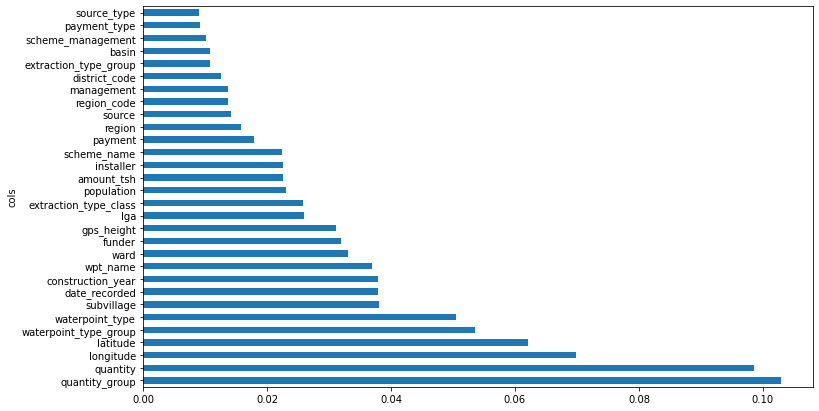

In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [54]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

31

We can retrain our model using just this subset of the columns:

In [55]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [56]:
m = rf(xs_imp, y)

And here's the result:

In [57]:
yt_pre = m.predict(xs_imp)
yv_pre = m.predict(valid_xs_imp)


In [58]:
accuracy_score(y, yt_pre)

0.8528993640104752

In [59]:
accuracy_score(valid_y, yv_pre)

0.8023569023569024

Our accuracy is about the same, but we have far fewer columns to study:

In [60]:
len(xs.columns), len(xs_imp.columns)

(39, 31)

We've found that generally the first step to improving a model is simplifying it—83 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

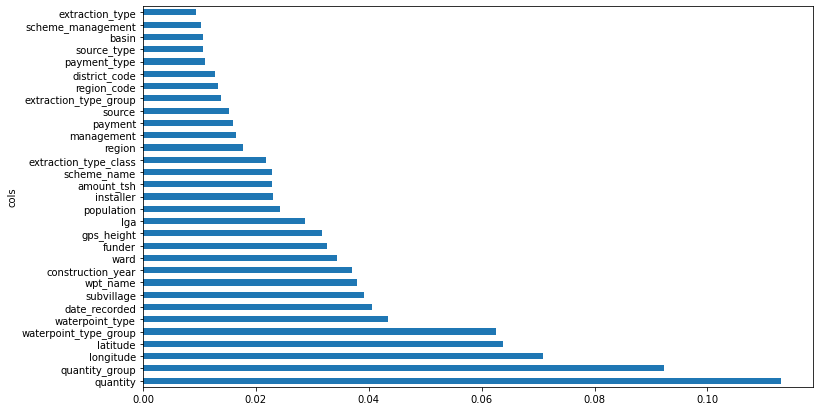

In [61]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `GarageArea` and `GarageCars`. Let's try to remove any redundent features. 

### Removing Redundant Features

Let's start with:

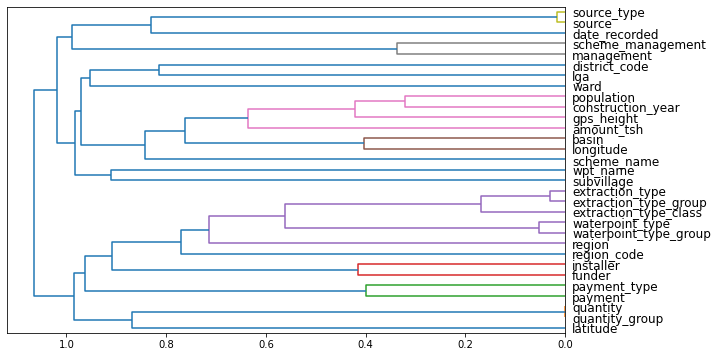

In [62]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. 

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [51]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=500, min_samples_leaf=15,
        max_samples=20000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [52]:
get_oob(xs_imp)

0.7773101384212495

Now we try removing each of our potentially redundant variables, one at a time:

In [63]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'source_type','waterpoint_type','extraction_type')}

{'extraction_type': 0.7870370370370371,
 'source_type': 0.7869809203142536,
 'waterpoint_type': 0.786307519640853}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [66]:
to_drop = ['source_type','waterpoint_type','extraction_type']
get_oob(xs_imp.drop(to_drop, axis=1))

0.7859895248784138

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [67]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [68]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [69]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [70]:
xs_final.columns

Index(['quantity_group', 'quantity', 'longitude', 'latitude',
       'waterpoint_type_group', 'subvillage', 'date_recorded',
       'construction_year', 'wpt_name', 'ward', 'funder', 'gps_height', 'lga',
       'extraction_type_class', 'population', 'amount_tsh', 'installer',
       'scheme_name', 'payment', 'region', 'source', 'region_code',
       'management', 'district_code', 'extraction_type_group', 'basin',
       'scheme_management', 'payment_type'],
      dtype='object')

In [71]:
m.predict(to_tst[xs_imp.columns])

array([2, 0, 2, ..., 0, 0, 2], dtype=int8)

##Neural Networks

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [72]:
df_nn = pd.read_csv(path/'train.csv', low_memory=False)

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network , plus high cardinality ones:

In [73]:
df_nn_final= df_nn[list(xs.columns) + [dep_var]]

In [74]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 55765 non-null  object 
 2   installer              55745 non-null  object 
 3   wpt_name               59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   subvillage             59029 non-null  object 
 6   region                 59400 non-null  object 
 7   lga                    59400 non-null  object 
 8   ward                   59400 non-null  object 
 9   public_meeting         56066 non-null  object 
 10  recorded_by            59400 non-null  object 
 11  scheme_management      55523 non-null  object 
 12  scheme_name            31234 non-null  object 
 13  permit                 56344 non-null  object 
 14  extraction_type        59400 non-null  object 
 15  ex

In [75]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=5, dep_var=dep_var)

In [76]:
cont_nn

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [77]:
df_nn_final[cat_nn].nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
                         ...  
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
Length: 30, dtype: int64

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [78]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [79]:
dls = to_nn.dataloaders(128)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [80]:
learn = tabular_learner(dls, layers=[500,250], metrics=accuracy)

SuggestedLRs(valley=0.0014454397605732083)

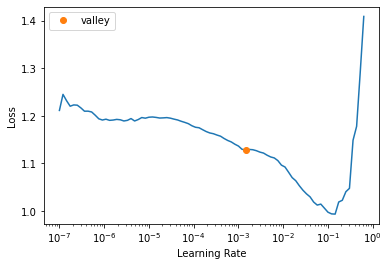

In [81]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [82]:
learn.fit_one_cycle(5, 0.001,wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.593675,0.578059,0.765993,00:06
1,0.417998,0.597638,0.750842,00:06
2,0.190604,0.710692,0.759428,00:06
3,0.089873,0.869056,0.758249,00:06
4,0.044183,0.959226,0.760438,00:06


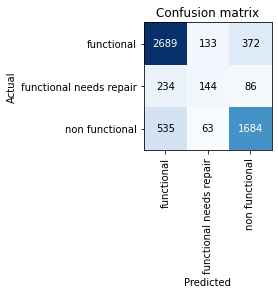

In [83]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [84]:
learn.save(path/'nn')

Path('nn.pth')

In [85]:
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [86]:
del (df_test['id'])

In [87]:
to_test = TabularPandas(df_test, procs, cat_nn, cont_nn)

In [88]:
test_dl = dls.test_dl(df_test, with_labels=False)

In [89]:
preds = learn.get_preds(dl=test_dl)

In [90]:
import pandas as pd
#preds[0]

pada = pd.DataFrame(preds[0]).astype("float")

In [91]:
pada['pred'] = pada.apply(lambda x: x.argmax(), axis=1)

In [92]:
pada['pred'].value_counts()

0    8863
2    5198
1     789
Name: pred, dtype: int64

In [107]:
df_test_id = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [108]:
df_test_id =  pd.concat([df_test_id, pada],axis=1)

In [115]:
submission = pd.read_csv('/content/gdrive/MyDrive/Water/SubmissionFormat.csv')

In [116]:
df_test_id = pd.merge(df_test_id,submission,on = 'id' )

In [117]:
df_test_id.columns

Index([                   'id',            'amount_tsh',
               'date_recorded',                'funder',
                  'gps_height',             'installer',
                   'longitude',              'latitude',
                    'wpt_name',           'num_private',
                       'basin',            'subvillage',
                      'region',           'region_code',
               'district_code',                   'lga',
                        'ward',            'population',
              'public_meeting',           'recorded_by',
           'scheme_management',           'scheme_name',
                      'permit',     'construction_year',
             'extraction_type', 'extraction_type_group',
       'extraction_type_class',            'management',
            'management_group',               'payment',
                'payment_type',         'water_quality',
               'quality_group',              'quantity',
              'quantity_group',

In [118]:
df_test_id.loc[df_test_id['pred'] == 0, 'status_group'] = 'functional'
df_test_id.loc[df_test_id['pred'] == 1, 'status_group'] = 'functional needs repair'
df_test_id.loc[df_test_id['pred'] == 2, 'status_group'] = 'non functional'

In [119]:
df_test_id['status_group'].value_counts()

functional                 8863
non functional             5198
functional needs repair     789
Name: status_group, dtype: int64

In [120]:
df_test_id

,id,amount_tsh,date_recorded,funder,...,1,2,pred,status_group
0,50785,0.0,2013-02-04,Dmdd,...,0.045060,0.552593,2,non functional
1,51630,0.0,2013-02-04,Government Of Tanzania,...,0.016532,0.720214,2,non functional
2,17168,0.0,2013-02-01,NaN,...,0.009873,0.000877,0,functional
3,45559,0.0,2013-01-22,Finn Water,...,0.000003,0.999984,2,non functional
4,49871,500.0,2013-03-27,Bruder,...,0.004552,0.000009,0,functional
...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,...,0.003230,0.086023,0,functional
14846,18990,1000.0,2011-03-21,Hiap,...,0.000240,0.005484,0,functional
14847,28749,0.0,2013-03-04,NaN,...,0.161301,0.164824,0,functional
14848,33492,0.0,2013-02-18,Germany,...,0.002925,0.000389,0,functional


In [121]:
df_test_id['rf'] = np.nan

In [122]:
df_test_id.loc[:,'rf'] = m.predict(to_tst[xs_imp.columns])

In [123]:
df_test_id.loc[(df_test_id['pred'] == 0) & (df_test_id['rf'] == 1), 'status_group'] = 'functional needs repair'
df_test_id.loc[(df_test_id['pred'] == 1) & (df_test_id['rf'] == 0), 'status_group'] = 'functional'
df_test_id.loc[(df_test_id['pred'] == 2) & (df_test_id['rf'] == 0), 'status_group'] = 'functional'

In [124]:
df_test_id['status_group'].value_counts()

functional                 10426
non functional              4024
functional needs repair      400
Name: status_group, dtype: int64

In [125]:
df_test_id.to_csv('solution.csv')